In [4]:
#!/usr/bin/python3 
import pandas as pd  # dataframe Series等的操作
import numpy as np  # 一些函数，如log等    
from fbprophet import Prophet  # facebook prophet 框架对象
from sklearn.metrics import mean_squared_error  # 均值方差错误检测函数 sklearn包中有很多其他函数
from fbprophet.diagnostics import cross_validation  # 交叉验证函数
import matplotlib.pyplot as plt # Python 的 2D绘图库
import math  # 
#?plt.hist()查看帮助

In [5]:
df2014 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20141231.csv')
# print(type(df))  #<class 'pandas.core.frame.DataFrame'>
df2015 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20151231.csv')
df2016 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20161231.csv')
df2017 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20171231.csv')

df_2years = pd.concat([df2014, df2015])
df_3years = pd.concat([df2014, df2015, df2016])
df_4years = pd.concat([df2014, df2015, df2016, df2017])

dflist = [df2014, df_2years, df_3years, df_4years]
# print(type(dflist))  #<class 'list'>
for i in range(len(dflist)):
    #dflist[i] = dflist[i][dflist[i].columns[0:2]]
    '''
    这个loc的用法是对行、对列的一种筛选。 
    大多数情况下的应用场景是用数字取行，用str取列。 
    比如loc[0:3,[“a”,”b”]]。取0到第3行（左闭右开，非整型值时左闭右闭），”a”列与”b”列。
    '''
    dflist[i] = dflist[i].loc[:,('Date', 'Sales')]
    #对列重命名
    dflist[i].columns = ['ds', 'y']
    #去除$
    dflist[i].y = dflist[i].y.str.replace("$","")
    # print(type(df.y)) <class 'pandas.core.series.Series'>
    # print(df.y.str) <pandas.core.strings.StringMethods object at 0x7f92751deb70>
    #str 转float
    dflist[i].y = dflist[i].y.astype(float)
    # 取指数，达成正态分布？
    dflist[i]['y'] = np.log(dflist[i]['y'])
    #df['cap'] = 20 #logistic 模型时可以设置上限cap

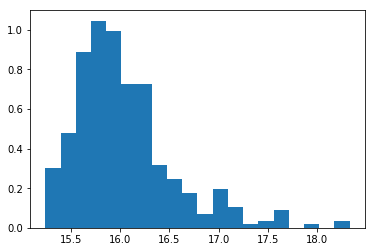

In [15]:
# plt.hist直方图
# bin指定(箱子)的个数,也就是总共有几条条状图, density=true 标准化 积分（直方图下的面积）为1
plt.hist(dflist[0].y, bins=20, density=True)
plt.show()

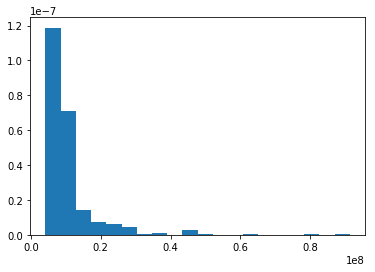

In [149]:
# 查看重新e次方之后原始数据的直方图
# pandas的map方法可以简而言之这样解释:对dataframe的每个元素执行func函数,用法基本如下:df.map(func),输入的应该是一个函数
plt.hist(dflist[0].y.map(lambda x: math.exp(x)), bins=20, density=True)
plt.show()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/wallen/.local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecast

        mape        mse            time_period
0   0.046299   1.318291            2014+yearly
1   0.046299   1.318287    2014+yearly&holiday
2   0.025924   0.863710           2014+default
3   0.010893   0.083914          2years+yearly
4   0.016533   0.135114  2years+yearly&holiday
5   0.203011  11.153033         2years+default
6   0.010857   0.094348          3years+yearly
7   0.010671   0.086881  3years+yearly&holiday
8   0.010857   0.094348         3years+default
9   0.012068   0.091114          4years+yearly
10  0.010963   0.079968  4years+yearly&holiday
11  0.012068   0.091114         4years+default


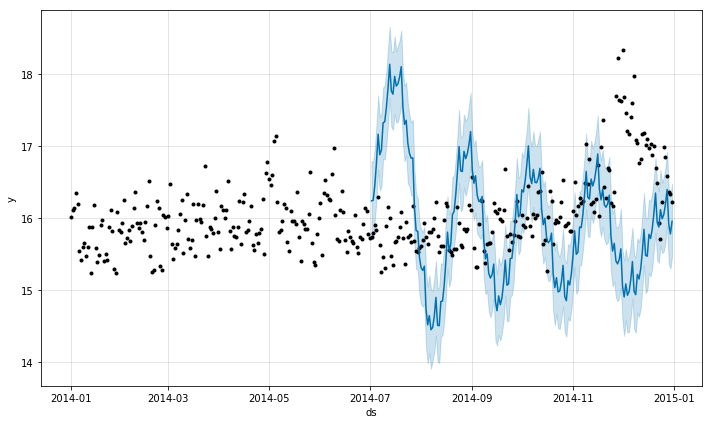

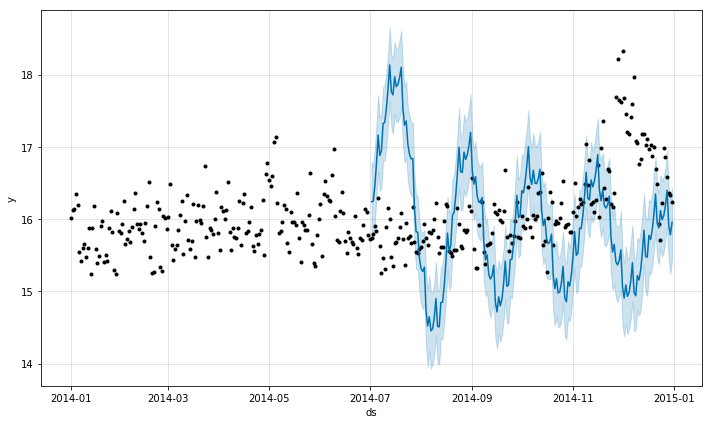

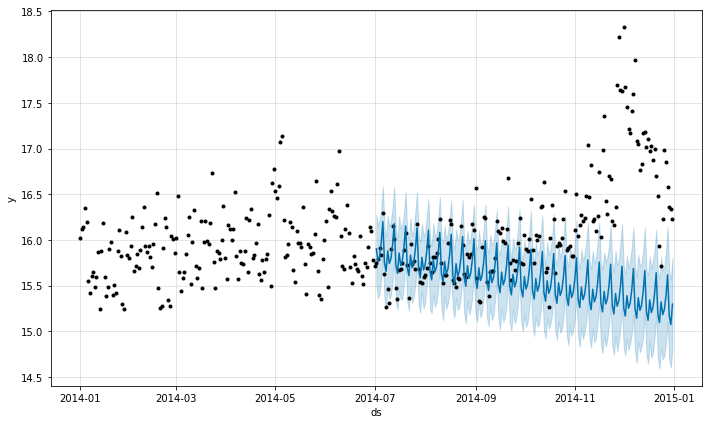

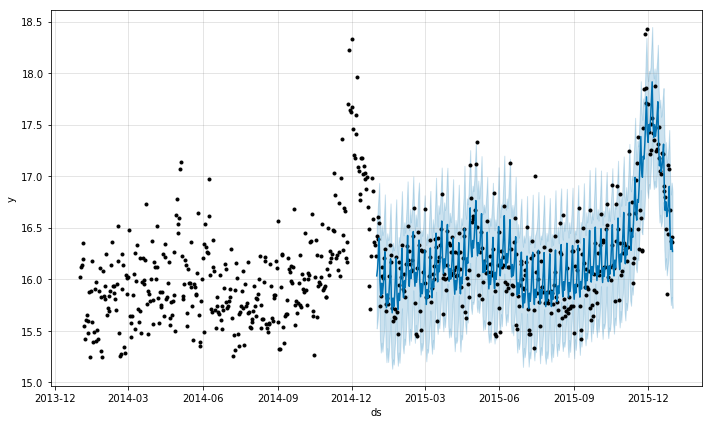

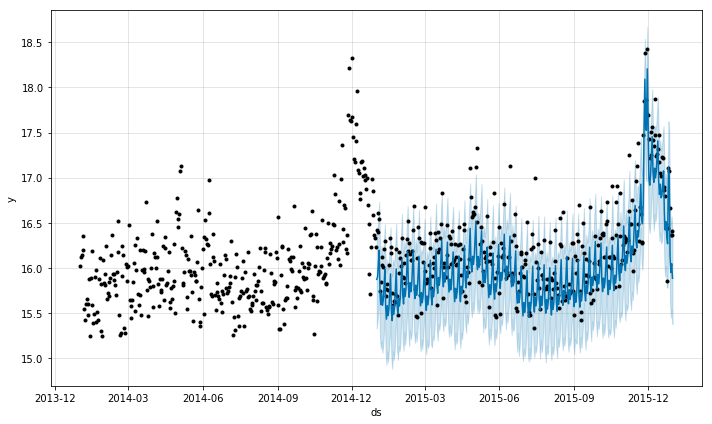

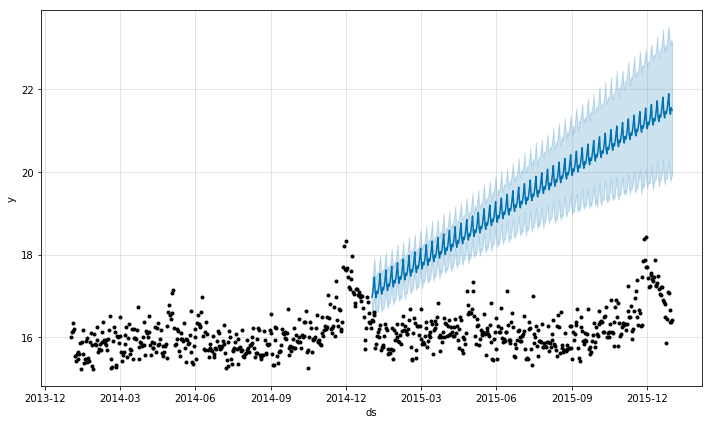

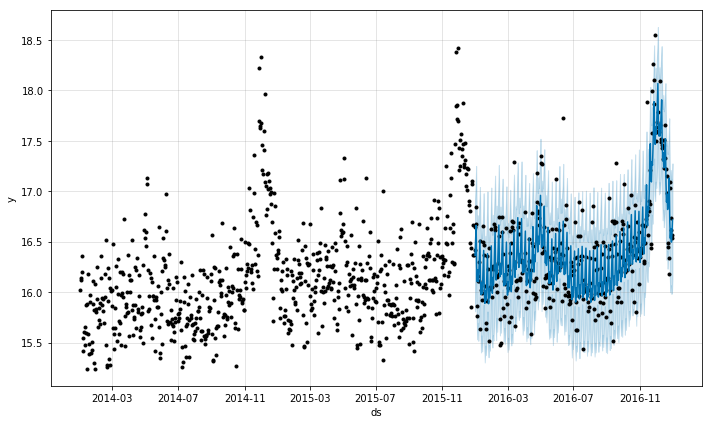

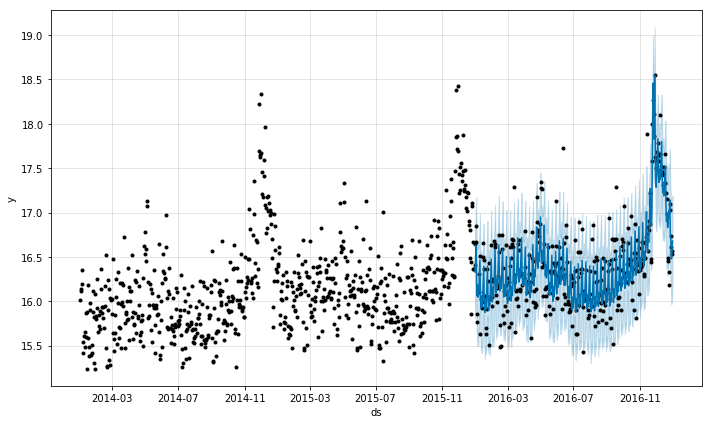

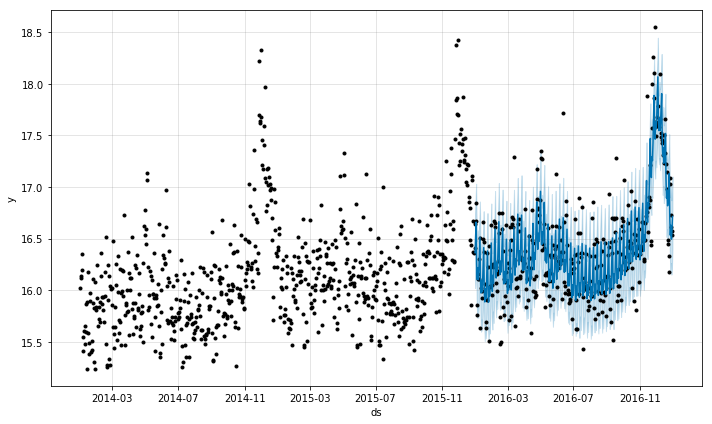

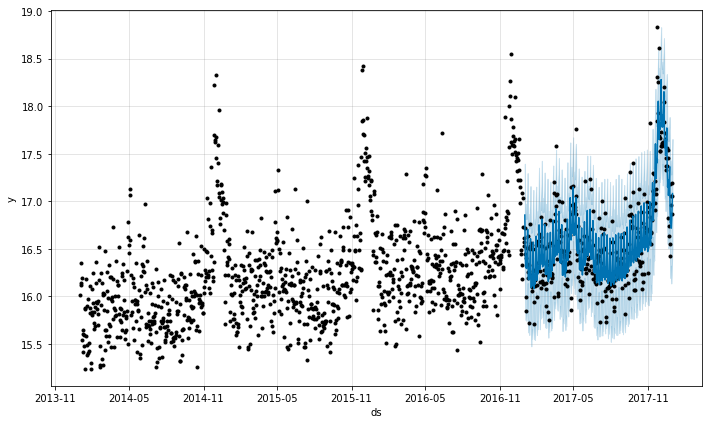

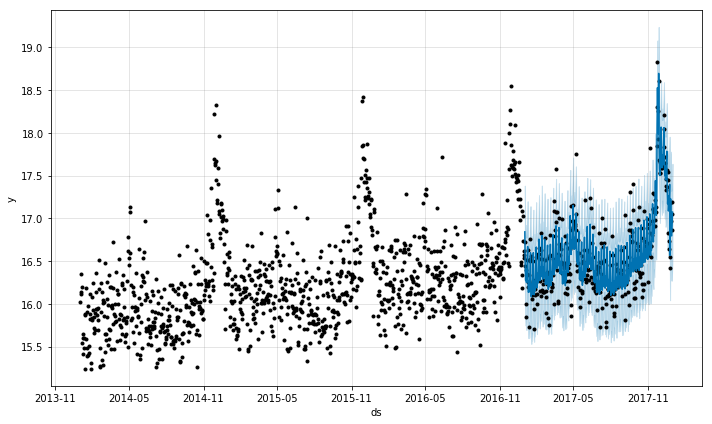

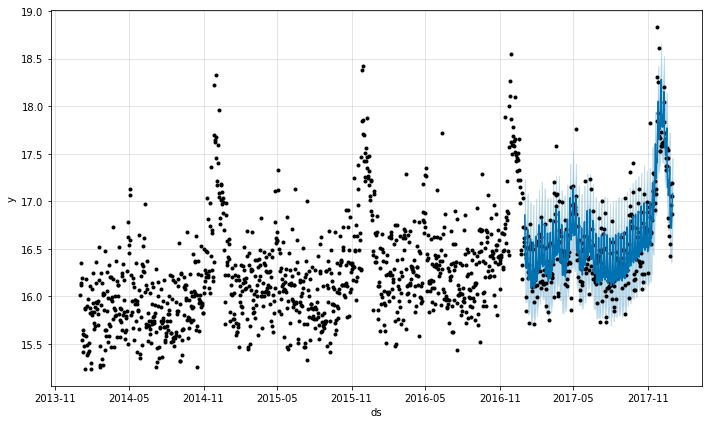

In [6]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']),
  'lower_window': 0,
  'upper_window': 3,
})
thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23']),
  'lower_window': 0,
  'upper_window': 5,
})

holidays = pd.concat((christmas, thanksgiving))




validation_args0= ['183 days', '182 days', '0 days']
validation_args1= ['365 days', '365 days', '0 days']
validation_args2= ['366 days', '730 days', '0 days']
validation_args3= ['365 days', '1096 days', '0 days']
vlist = [validation_args0, validation_args1, validation_args2, validation_args3]

cast_number = [182, 365, 730, 1096]
result_list = []


years = ['2014', '2years', '3years', '4years']
models = ['yearly', 'yearly&holiday', 'default']

for i in range(len(dflist)):
    m_default = Prophet()
    # mcmc_samples = 200
    m = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True,
               holidays_prior_scale=0.95, interval_width=0.95)
    # mcmc_samples = 200
    m_with_holiday = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True,
               holidays_prior_scale=0.95, interval_width=0.95, holidays = holidays)
    # m_default放到list的第一个就报错。。。
    mlist = [m, m_with_holiday, m_default]
    for j in range(len(mlist)):
        mlist[j].fit(dflist[i])
        # period一定为准确的年份倍数，若三个参数均为年份
        df_cv = cross_validation(mlist[j], horizon = vlist[i][0], period = vlist[i][1], initial= vlist[i][2])
        mse = mean_squared_error(dflist[i].y[cast_number[i]:], df_cv.yhat)
        
        # 如果不用Series,values方法， 剪裁过的series序号不同将无法相减！用这个方法会将其变成一个纯数组
        mape = np.median(np.true_divide(np.abs(df_cv.yhat.values - (dflist[i].y[cast_number[i]:].values)), dflist[i].y[cast_number[i]:].values))
        result = dict()
        result['time_period'] = years[i] + '+' + models[j]
        result['mse'] = mse
        result['mape'] = mape
        result_list.append(result)
        m.plot(df_cv);

print(pd.DataFrame(result_list))

In [12]:
future = m_with_holiday.make_future_dataframe(periods=731)
#future['cap'] = 20
future.tail()

,ds
2187,2019-12-28
2188,2019-12-29
2189,2019-12-30
2190,2019-12-31
2191,2020-01-01


In [13]:
forecast = m_with_holiday.predict(future)
print(type(forecast))
forecast.tail()
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#forecast[(forecast['christmas'] + forecast['thanksgiving']).abs() > 0][
 #       ['ds', 'christmas', 'thanksgiving']][-10:]

<class 'pandas.core.frame.DataFrame'>


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,christmas,christmas_lower,christmas_upper,holidays,...,thanksgiving,thanksgiving_lower,thanksgiving_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
2187,2019-12-28,17.025603,17.002577,17.051408,16.801525,17.876309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.120134,0.120134,0.120134,0.190197,0.190197,0.190197,17.335934
2188,2019-12-29,17.026105,17.003011,17.051937,16.926556,18.004794,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.307921,0.307921,0.307921,0.145707,0.145707,0.145707,17.479733
2189,2019-12-30,17.026607,17.003444,17.052467,16.554121,17.622091,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.052488,-0.052488,-0.052488,0.104124,0.104124,0.104124,17.078243
2190,2019-12-31,17.027109,17.003878,17.052996,16.398590,17.466680,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.155747,-0.155747,-0.155747,0.065512,0.065512,0.065512,16.936874
2191,2020-01-01,17.027611,17.004314,17.053525,16.515857,17.535676,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.034574,-0.034574,-0.034574,0.029876,0.029876,0.029876,17.022913


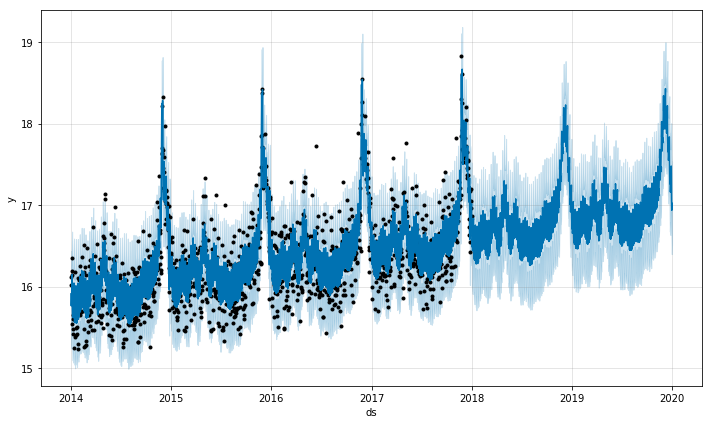

In [14]:
m_with_holiday.plot(forecast);

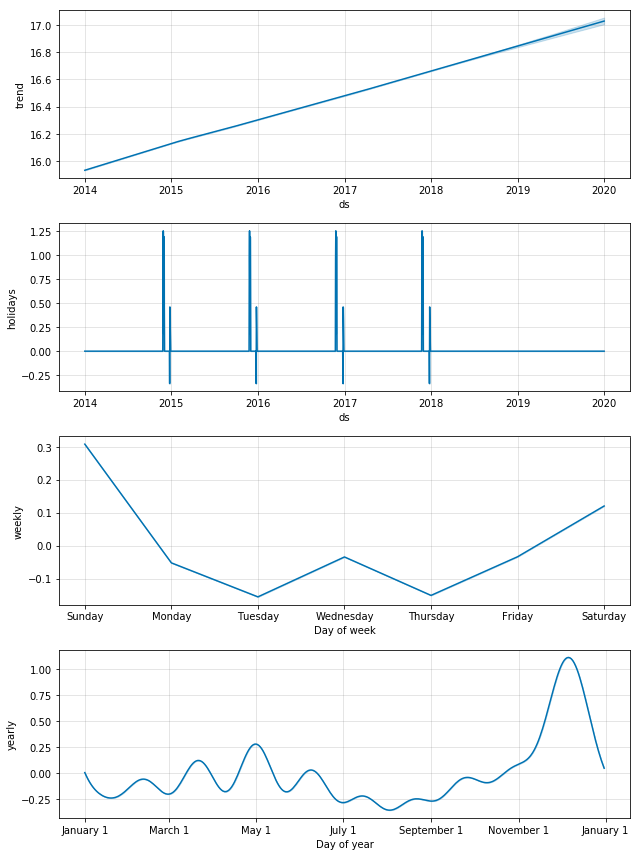

In [15]:
m_with_holiday.plot_components(forecast);

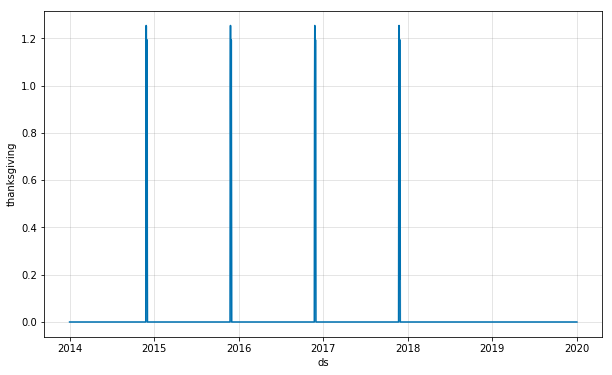

In [16]:
m_with_holiday.plot_forecast_component(forecast, 'thanksgiving')

In [18]:
m_with_holiday.predictive_samples(future)

{'seasonal': array([[-0.02141089, -0.02141089, -0.02141089, ..., -0.02141089,
         -0.02141089, -0.02141089],
        [-0.16938501, -0.16938501, -0.16938501, ..., -0.16938501,
         -0.16938501, -0.16938501],
        [-0.08053336, -0.08053336, -0.08053336, ..., -0.08053336,
         -0.08053336, -0.08053336],
        ...,
        [ 0.05163616,  0.05163616,  0.05163616, ...,  0.05163616,
          0.05163616,  0.05163616],
        [-0.09023474, -0.09023474, -0.09023474, ..., -0.09023474,
         -0.09023474, -0.09023474],
        [-0.00469773, -0.00469773, -0.00469773, ..., -0.00469773,
         -0.00469773, -0.00469773]]),
 'trend': array([[15.93306004, 15.93306004, 15.93306004, ..., 15.93306004,
         15.93306004, 15.93306004],
        [15.93359783, 15.93359783, 15.93359783, ..., 15.93359783,
         15.93359783, 15.93359783],
        [15.93413563, 15.93413563, 15.93413563, ..., 15.93413563,
         15.93413563, 15.93413563],
        ...,
        [17.01794955, 17.0090211 